# Initialize

In [17]:
import os
import sys
sys.path.insert(0, os.path.abspath("lib"))

#@title Run to install MuJoCo and `dm_control`
import distutils.util
import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

print('Installing dm_control...')
!pip install -q dm_control>=1.0.8

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")
!rm -r "=1.0.8"

#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import Adam

# import this first to resolve the issue.
from acme import wrappers
from model import *
from utils import *
# Soft-Actor-Critic Model
from sac import *
from replay_memory import *

# try out the wrappers
from acme import wrappers
from dm_control import suite

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'retina'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)


######  Environment wrappers  ####
from dm_env import specs


# environment wrappers
class NormilizeActionSpecWrapper(wrappers.EnvironmentWrapper):
    """Turn each dimension of the actions into the range of [-1, 1]."""

    def __init__(self, environment):
        super().__init__(environment)

        action_spec = environment.action_spec()
        self._scale = action_spec.maximum - action_spec.minimum
        self._offset = action_spec.minimum

        minimum = action_spec.minimum * 0 - 1.
        maximum = action_spec.minimum * 0 + 1.
        self._action_spec = specs.BoundedArray(
            action_spec.shape,
            action_spec.dtype,
            minimum,
            maximum,
            name=action_spec.name)

    def _from_normal_actions(self, actions):
        actions = 0.5 * (actions + 1.0)  # a_t is now in the range [0, 1]
        # scale range to [minimum, maximum]
        return actions * self._scale + self._offset

    def step(self, action):
        action = self._from_normal_actions(action)
        return self._environment.step(action)

    def action_spec(self):
        return self._action_spec


class MujocoActionNormalizer(wrappers.EnvironmentWrapper):
    """Rescale actions to [-1, 1] range for mujoco physics engine.

    For control environments whose actions have bounded range in [-1, 1], this
      adaptor rescale actions to the desired range. This allows actor network to
      output unscaled actions for better gradient dynamics.
    """

    def __init__(self, environment, rescale='clip'):
        super().__init__(environment)
        self._rescale = rescale

    def step(self, action):
        """Rescale actions to [-1, 1] range before stepping wrapped environment."""
        if self._rescale == 'tanh':
            scaled_actions = tree.map_structure(np.tanh, action)
        elif self._rescale == 'clip':
            scaled_actions = tree.map_structure(lambda a: np.clip(a, -1., 1.), action)
        else:
            raise ValueError('Unrecognized scaling option: %s' % self._rescale)
        return self._environment.step(scaled_actions)



Installing dm_control...
env: MUJOCO_GL=egl
Checking that the dm_control installation succeeded...
Installed dm_control 1.0.8


## Environment wrappers

In [2]:
#@title Environment wrappers
from dm_env import specs


# environment wrappers
class NormilizeActionSpecWrapper(wrappers.EnvironmentWrapper):
    """Turn each dimension of the actions into the range of [-1, 1]."""

    def __init__(self, environment):
        super().__init__(environment)

        action_spec = environment.action_spec()
        self._scale = action_spec.maximum - action_spec.minimum
        self._offset = action_spec.minimum

        minimum = action_spec.minimum * 0 - 1.
        maximum = action_spec.minimum * 0 + 1.
        self._action_spec = specs.BoundedArray(
            action_spec.shape,
            action_spec.dtype,
            minimum,
            maximum,
            name=action_spec.name)

    def _from_normal_actions(self, actions):
        actions = 0.5 * (actions + 1.0)  # a_t is now in the range [0, 1]
        # scale range to [minimum, maximum]
        return actions * self._scale + self._offset

    def step(self, action):
        action = self._from_normal_actions(action)
        return self._environment.step(action)

    def action_spec(self):
        return self._action_spec


class MujocoActionNormalizer(wrappers.EnvironmentWrapper):
    """Rescale actions to [-1, 1] range for mujoco physics engine.

    For control environments whose actions have bounded range in [-1, 1], this
      adaptor rescale actions to the desired range. This allows actor network to
      output unscaled actions for better gradient dynamics.
    """

    def __init__(self, environment, rescale='clip'):
        super().__init__(environment)
        self._rescale = rescale

    def step(self, action):
        """Rescale actions to [-1, 1] range before stepping wrapped environment."""
        if self._rescale == 'tanh':
            scaled_actions = tree.map_structure(np.tanh, action)
        elif self._rescale == 'clip':
            scaled_actions = tree.map_structure(lambda a: np.clip(a, -1., 1.), action)
        else:
            raise ValueError('Unrecognized scaling option: %s' % self._rescale)
        return self._environment.step(scaled_actions)



## Helper functions Moved to `utils.py`

## Environment and agent setup

**NOTE: Make sure you download the pretrained weights or upload your own weights before running this cell!**

In [52]:
# load the environment
env = suite.load(domain_name="hopper", task_name="hop")
# add wrappers onto the environment
env = NormilizeActionSpecWrapper(env)
env = MujocoActionNormalizer(environment=env, rescale='clip')
env = wrappers.SinglePrecisionWrapper(env)


class Args:
    env_name = 'whatever'
    policy = 'Gaussian'
    eval = True
    gamma = 0.99
    tau = 0.005
    lr = 0.0003
    alpha = 0.2
    automatic_entropy_tuning = True
    seed = 42
    batch_size = 256
    num_steps = 1000000
    hidden_size = 1024
    updates_per_step = 1
    start_steps = 10000
    target_update_interval = 1
    replay_size = 1000000
    # use the cuda to speedup
    cuda = True


args = Args()

# get the dimensionality of the observation_spec after flattening
flat_obs = tree.flatten(env.observation_spec())
# combine all the shapes
obs_dim = sum([item.shape[0] for item in flat_obs])

# setup agent, using Soft-Actor-Critic Model
agent = SAC(obs_dim, env.action_spec(), args)
# load checkpoint - UPLOAD YOUR FILE HERE!
model_path = 'checkpoints/sac_checkpoint_hopper_hop1001_2225'
agent.load_checkpoint(model_path, evaluate=True)

# pull out model
model = agent.policy
# setup hook dict
hook_dict = init_hook_dict(model)
# add hooks
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        module.register_forward_hook(recordtodict_hook(name=name, hook_dict=hook_dict))

Loading models from checkpoints/sac_checkpoint_hopper_hop1001_2225


In [53]:
from IPython.display import display, HTML
# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

#@title Loading and simulating a `suite` task{vertical-output: true}

# Load the environment
# random_state = np.random.RandomState(42)
# env = suite.load('hopper', 'stand', task_kwargs={'random': random_state})

# Simulate episode with random actions
def visualize(duration=15, save=False, name="vids.mp4"):
    frames = []
    ticks = []
    rewards = []
    observations = []

    spec = env.action_spec()
    time_step = env.reset()

    while env.physics.data.time < duration:
        state = get_flat_obs(time_step)
        action = agent.select_action(state)
        time_step = env.step(action)

        camera0 = env.physics.render(camera_id=0, height=200, width=200)
        camera1 = env.physics.render(camera_id=1, height=200, width=200)
        frames.append(np.hstack((camera0, camera1)))
        rewards.append(time_step.reward)
        observations.append(copy.deepcopy(time_step.observation))
        ticks.append(env.physics.data.time)

    html_video = display_video(frames, framerate=1./env.control_timestep())

    # Show video and plot reward and observations
    num_sensors = len(time_step.observation)

    _, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
    ax[0].plot(ticks, rewards)
    ax[0].set_ylabel('reward')
    ax[-1].set_xlabel('time')

    for i, key in enumerate(time_step.observation):
        data = np.asarray([observations[j][key] for j in range(len(observations))])
        ax[i+1].plot(ticks, data, label=key)
        ax[i+1].set_ylabel(key)
    if save:
        save_video(frames, video_name=name)

    return html_video

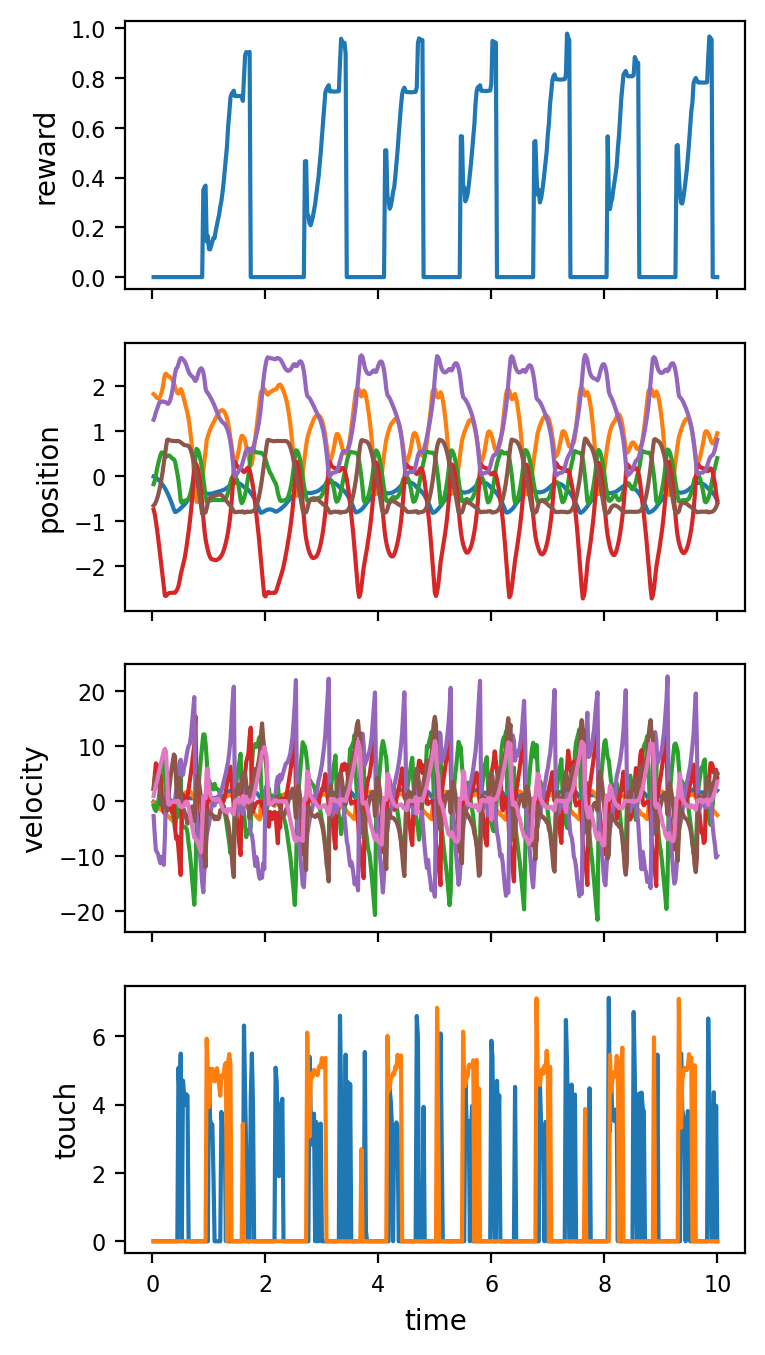

In [56]:
visualize(duration=10)

In [55]:
# Simulate episode with random actions
def visualize(duration=15, save=False, name="vids.mp4"):
    frames = []
    ticks = []
    rewards = []
    observations = []

    spec = env.action_spec()
    time_step = env.reset()

    while env.physics.data.time < duration:
        state = get_flat_obs(time_step)
        action = agent.select_action(state)
        time_step = env.step(action)

        camera0 = env.physics.render(camera_id=0, height=400, width=400)
        camera1 = env.physics.render(camera_id=1, height=400, width=400)
        frame = np.hstack((camera0, camera1))
        
        frames.append(frame)
        rewards.append(time_step.reward)
        observations.append(copy.deepcopy(time_step.observation))
        ticks.append(env.physics.data.time)

    html_video = display_video(frames, framerate=1./env.control_timestep())

    # Show video and plot reward and observations
    num_sensors = len(time_step.observation)

    _, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
    ax[0].plot(ticks, rewards)
    ax[0].set_ylabel('reward')
    ax[-1].set_xlabel('time')

    for i, key in enumerate(time_step.observation):
        data = np.asarray([observations[j][key] for j in range(len(observations))])
        ax[i+1].plot(ticks, data, label=key)
        ax[i+1].set_ylabel(key)
    if save:
        save_video(frames, video_name=name)

    return html_video

## Collecting activations and kinematics

In [5]:
HOPPER_GEOM_NAMES = ['floor', 'torso', 'nose', 'pelvis', 'thigh', 'calf', 'foot']
HOPPER_JOINT_NAMES = ["rootx", "rootz", "rooty", "waist", "hip", "knee", "ankle"]
HOPPER_ACTUATOR_NAMES = ["waist", "hip", "knee", "ankle"]

# get the mapping of the geom names
geom_names_to_idx = {geom_name: idx for idx, geom_name in enumerate(HOPPER_GEOM_NAMES)}
# get the mapping of the joint names
joint_names_to_idx = {joint_name: idx for idx, joint_name in enumerate(HOPPER_JOINT_NAMES)}
# get the mapping of the actuator names
actuator_names_to_idx = {actuator_name: idx for idx, actuator_name in enumerate(HOPPER_ACTUATOR_NAMES)}

In [6]:
# run a few episodes just to collect activations
num_episodes_to_run = 42

# for recording kinematics
total_kinematic_dict = {
    'geom_positions': [],
    'joint_angles': [],
    'joint_velocities': [],
    'actuator_forces': []
}

for i in range(num_episodes_to_run):
    time_step = env.reset()
    episode_reward = 0
    while not time_step.last():  # or env.get_termination()
        # get the state
        state = get_flat_obs(time_step)
        # sample an action
        action = agent.select_action(state)
        time_step = env.step(action)

        # record kinematics
        kinematic_dict = get_kinematics(env.physics, HOPPER_GEOM_NAMES, HOPPER_JOINT_NAMES, HOPPER_ACTUATOR_NAMES)
        total_kinematic_dict['geom_positions'].append(kinematic_dict['geom_positions'])
        total_kinematic_dict['joint_angles'].append(kinematic_dict['joint_angles'])
        total_kinematic_dict['joint_velocities'].append(kinematic_dict['joint_velocities'])
        total_kinematic_dict['actuator_forces'].append(kinematic_dict['actuator_forces'])
        # record reward
        episode_reward += time_step.reward
    print('Episode: {} Reward: {}'.format(i+1, episode_reward))

Episode: 1 Reward: 309.3778319272096
Episode: 2 Reward: 311.8377126061823
Episode: 3 Reward: 313.21291249990463
Episode: 4 Reward: 304.3169985921122
Episode: 5 Reward: 297.56805062294006
Episode: 6 Reward: 306.534777111141
Episode: 7 Reward: 301.20182490348816
Episode: 8 Reward: 297.3024739921093
Episode: 9 Reward: 298.44507808983326
Episode: 10 Reward: 309.25967670977116
Episode: 11 Reward: 298.39966686069965
Episode: 12 Reward: 297.4493210911751
Episode: 13 Reward: 295.3279329389334
Episode: 14 Reward: 297.31346775591373
Episode: 15 Reward: 321.6051764190197
Episode: 16 Reward: 303.2423337335931
Episode: 17 Reward: 297.67093504965305
Episode: 18 Reward: 313.812762722373
Episode: 19 Reward: 308.5868648394244
Episode: 20 Reward: 309.72147338540526
Episode: 21 Reward: 317.4379360228777
Episode: 22 Reward: 298.42065742611885
Episode: 23 Reward: 302.286156013608
Episode: 24 Reward: 298.03077605366707
Episode: 25 Reward: 301.4041437506676
Episode: 26 Reward: 318.23862768264553
Episode: 27 

In [7]:
# otherwise, just compile the hook_dict
# Which is the hidden state and weights of the model
loaded_hook_dict = compile_hook_dict(hook_dict)

In [8]:
# process the kinematics - convert the kinematics to numpy arrays
total_kinematic_dict['geom_positions'] = np.stack(total_kinematic_dict['geom_positions'],
                                                  axis=0)  # combine the geom_positions_arr into (t, n, 3)
total_kinematic_dict['joint_angles'] = np.array(total_kinematic_dict['joint_angles'])
total_kinematic_dict['joint_velocities'] = np.array(total_kinematic_dict['joint_velocities'])
total_kinematic_dict['actuator_forces'] = np.array(total_kinematic_dict['actuator_forces'])

In [9]:
# example 1: get the joint angles for the bthigh
waist_joint_angles = total_kinematic_dict['joint_angles'][:, joint_names_to_idx['waist']]

# example 2: get the geom positions for the torso
torso_geom_positions = total_kinematic_dict['geom_positions'][:, geom_names_to_idx['torso'], :]

In [10]:
total_kinematic_dict['joint_angles'].shape

(42000, 7)

In [11]:
total_kinematic_dict['geom_positions'].shape

(42000, 7, 3)

# PCA on joint angles

Text(1, 1, '1th component')

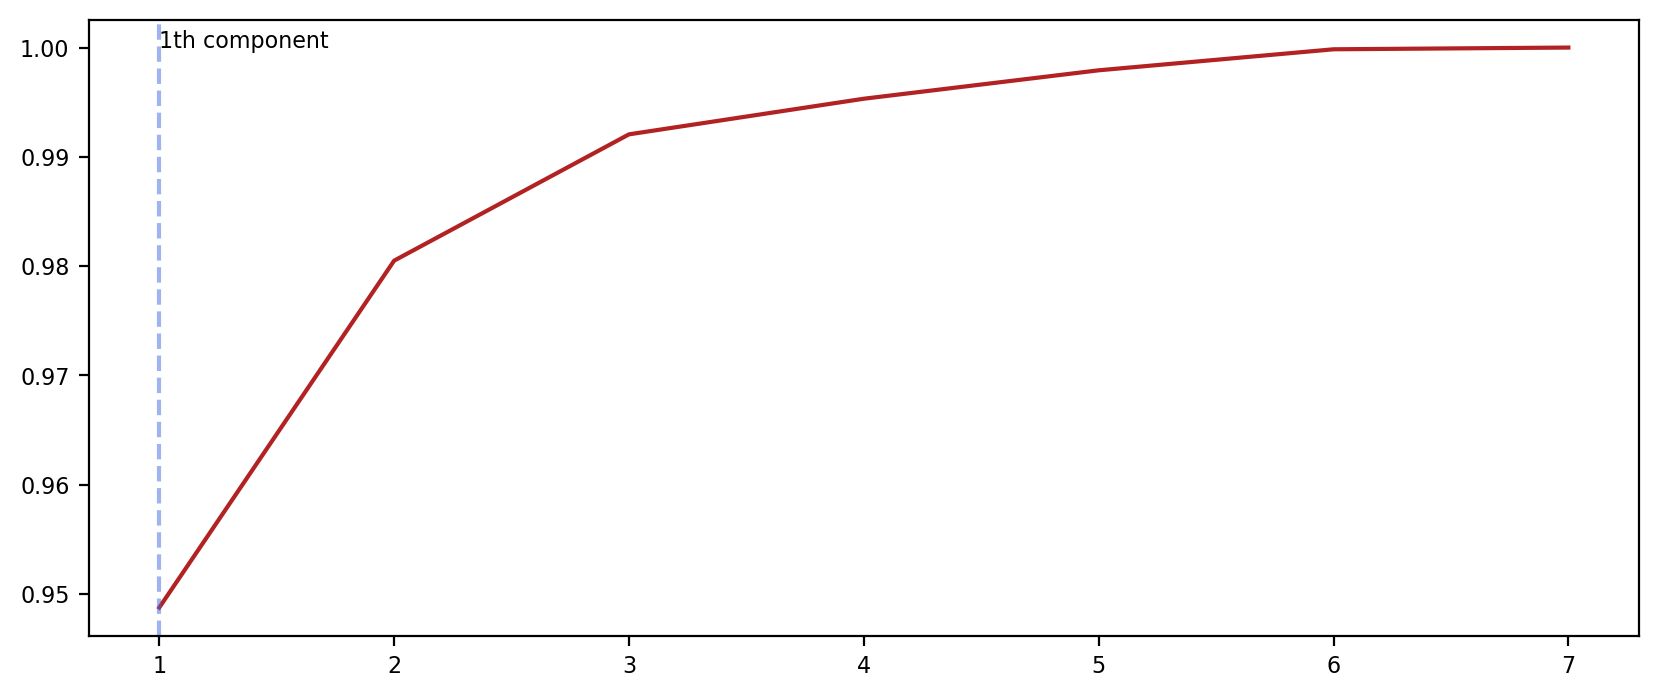

In [18]:
%matplotlib inline
angles = total_kinematic_dict["joint_angles"]
pca = PCA()
transformed = pca.fit_transform(angles)

fig = plt.figure(figsize=(10,4))
plt.plot(np.arange(1, angles.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), color='firebrick')

#This calculates the number of PCA components required to surpass teh variance threshold
comps_above_thresh = np.argwhere(np.cumsum(pca.explained_variance_ratio_)>0.95)[0][0]

plt.axvline(x=comps_above_thresh, color='royalblue', linestyle='--', alpha=0.5)
plt.text(x = comps_above_thresh, y = 1, s='%ith component'%comps_above_thresh)


PIL.Image.Image

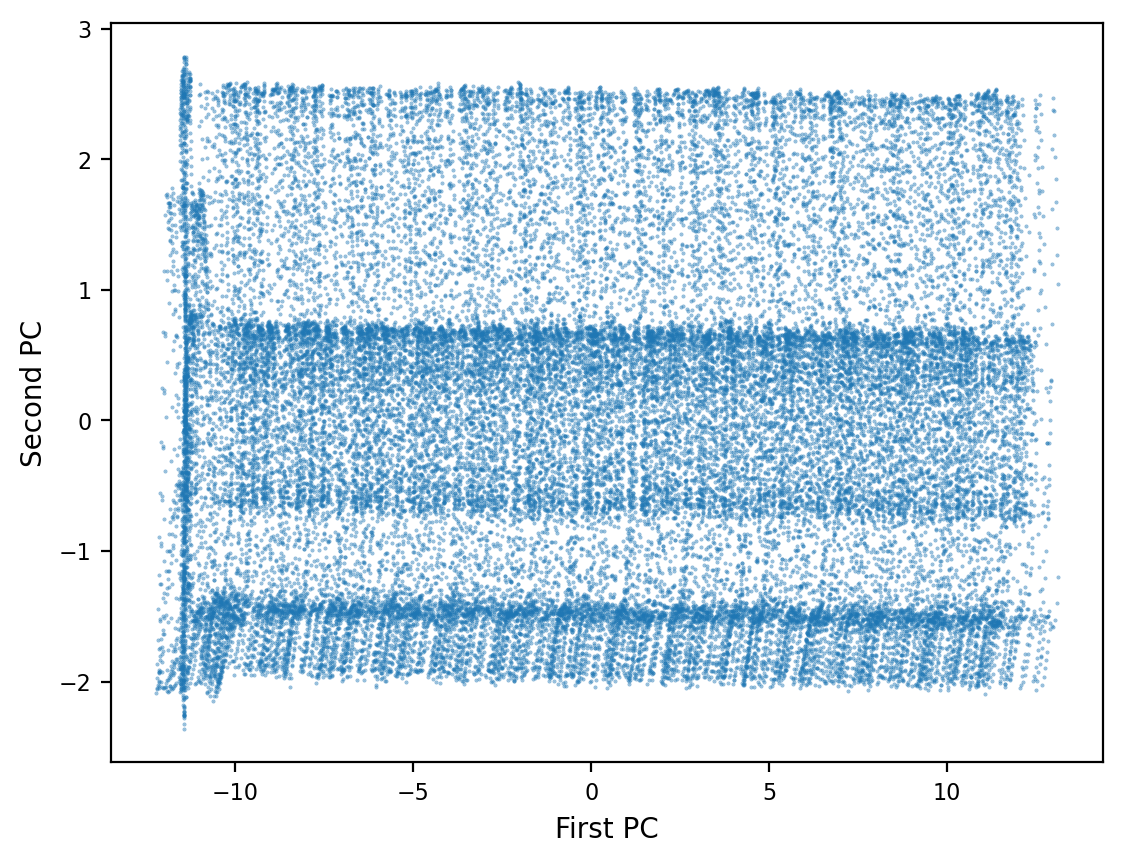

In [61]:
angles = total_kinematic_dict["joint_angles"]
pca = PCA(n_components=2)
reduced = pca.fit_transform(angles)
fig = plt.figure()
plt.scatter(reduced[:, 0], reduced[:, 1], s=0.2, alpha=0.5)
plt.xlabel("First PC")
plt.ylabel("Second PC")
a = fig2img(fig)
type(a)

In [47]:
import motionmapperpy as mmpy

projectPath = 'hopper_mmpy'

# This creates a project directory structure which will be used to store all motionmappery pipeline
# related data in one place.

mmpy.createProjectDirectory(projectPath)

#% Load the default parameters.
parameters = mmpy.setRunParameters() 

parameters


Skipping, path already exists : hopper_mmpy
Skipping, path already exists : hopper_mmpy/Projections
Skipping, path already exists : hopper_mmpy/TSNE_Projections
Skipping, path already exists : hopper_mmpy/TSNE
Skipping, path already exists : hopper_mmpy/UMAP


{'numProcessors': 12,
 'numPeriods': 25,
 'omega0': 5,
 'samplingFreq': 100,
 'minF': 1,
 'maxF': 50,
 'tSNE_method': 'barnes_hut',
 'perplexity': 32,
 'embedding_batchSize': 20000,
 'maxOptimIter': 100,
 'trainingSetSize': 35000,
 'maxNeighbors': 200,
 'kdNeighbors': 5,
 'training_perplexity': 20,
 'training_numPoints': 10000,
 'minTemplateLength': 1,
 'waveletDecomp': True,
 'useGPU': -1,
 'n_neighbors': 15,
 'train_negative_sample_rate': 5,
 'embed_negative_sample_rate': 1,
 'min_dist': 0.1,
 'umap_output_dims': 2,
 'n_training_epochs': 1000,
 'rescale_max': 100,
 'method': 'TSNE'}

In [48]:
angles.shape

(42000, 7)

	 Calculating wavelets, clock starting.
	 Using #12 CPUs.
	 Done at 0.41 seconds.


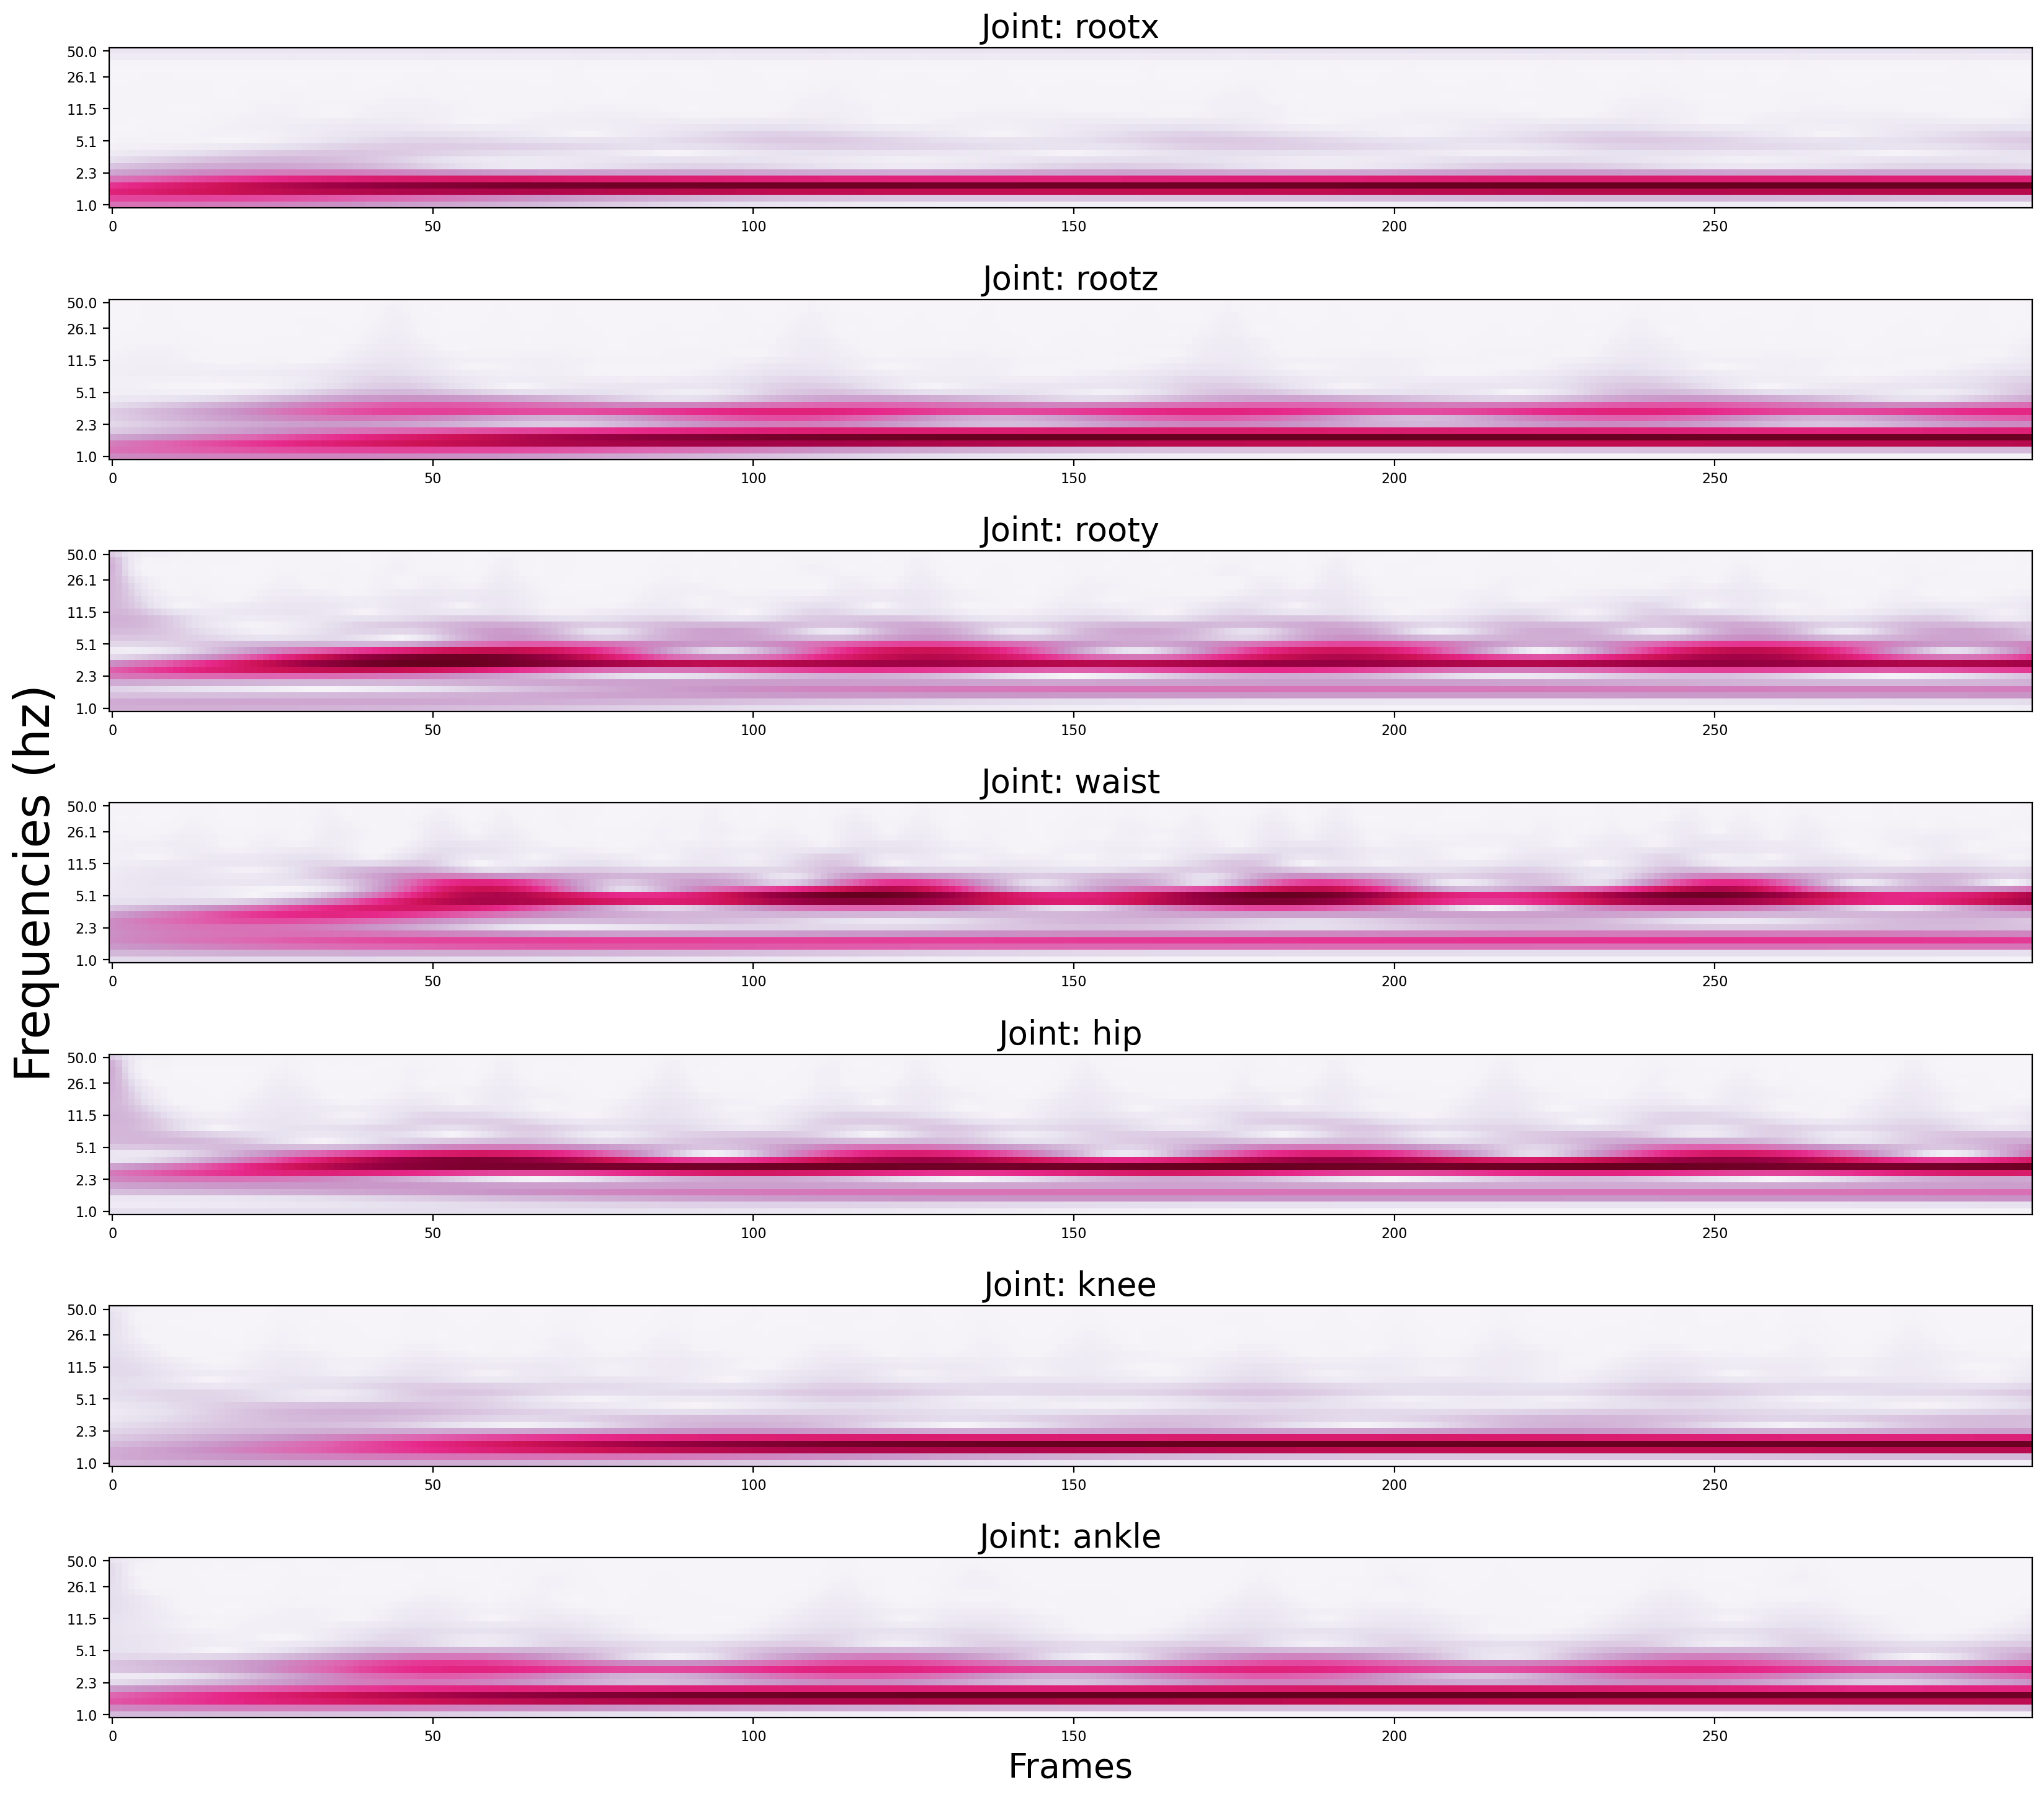

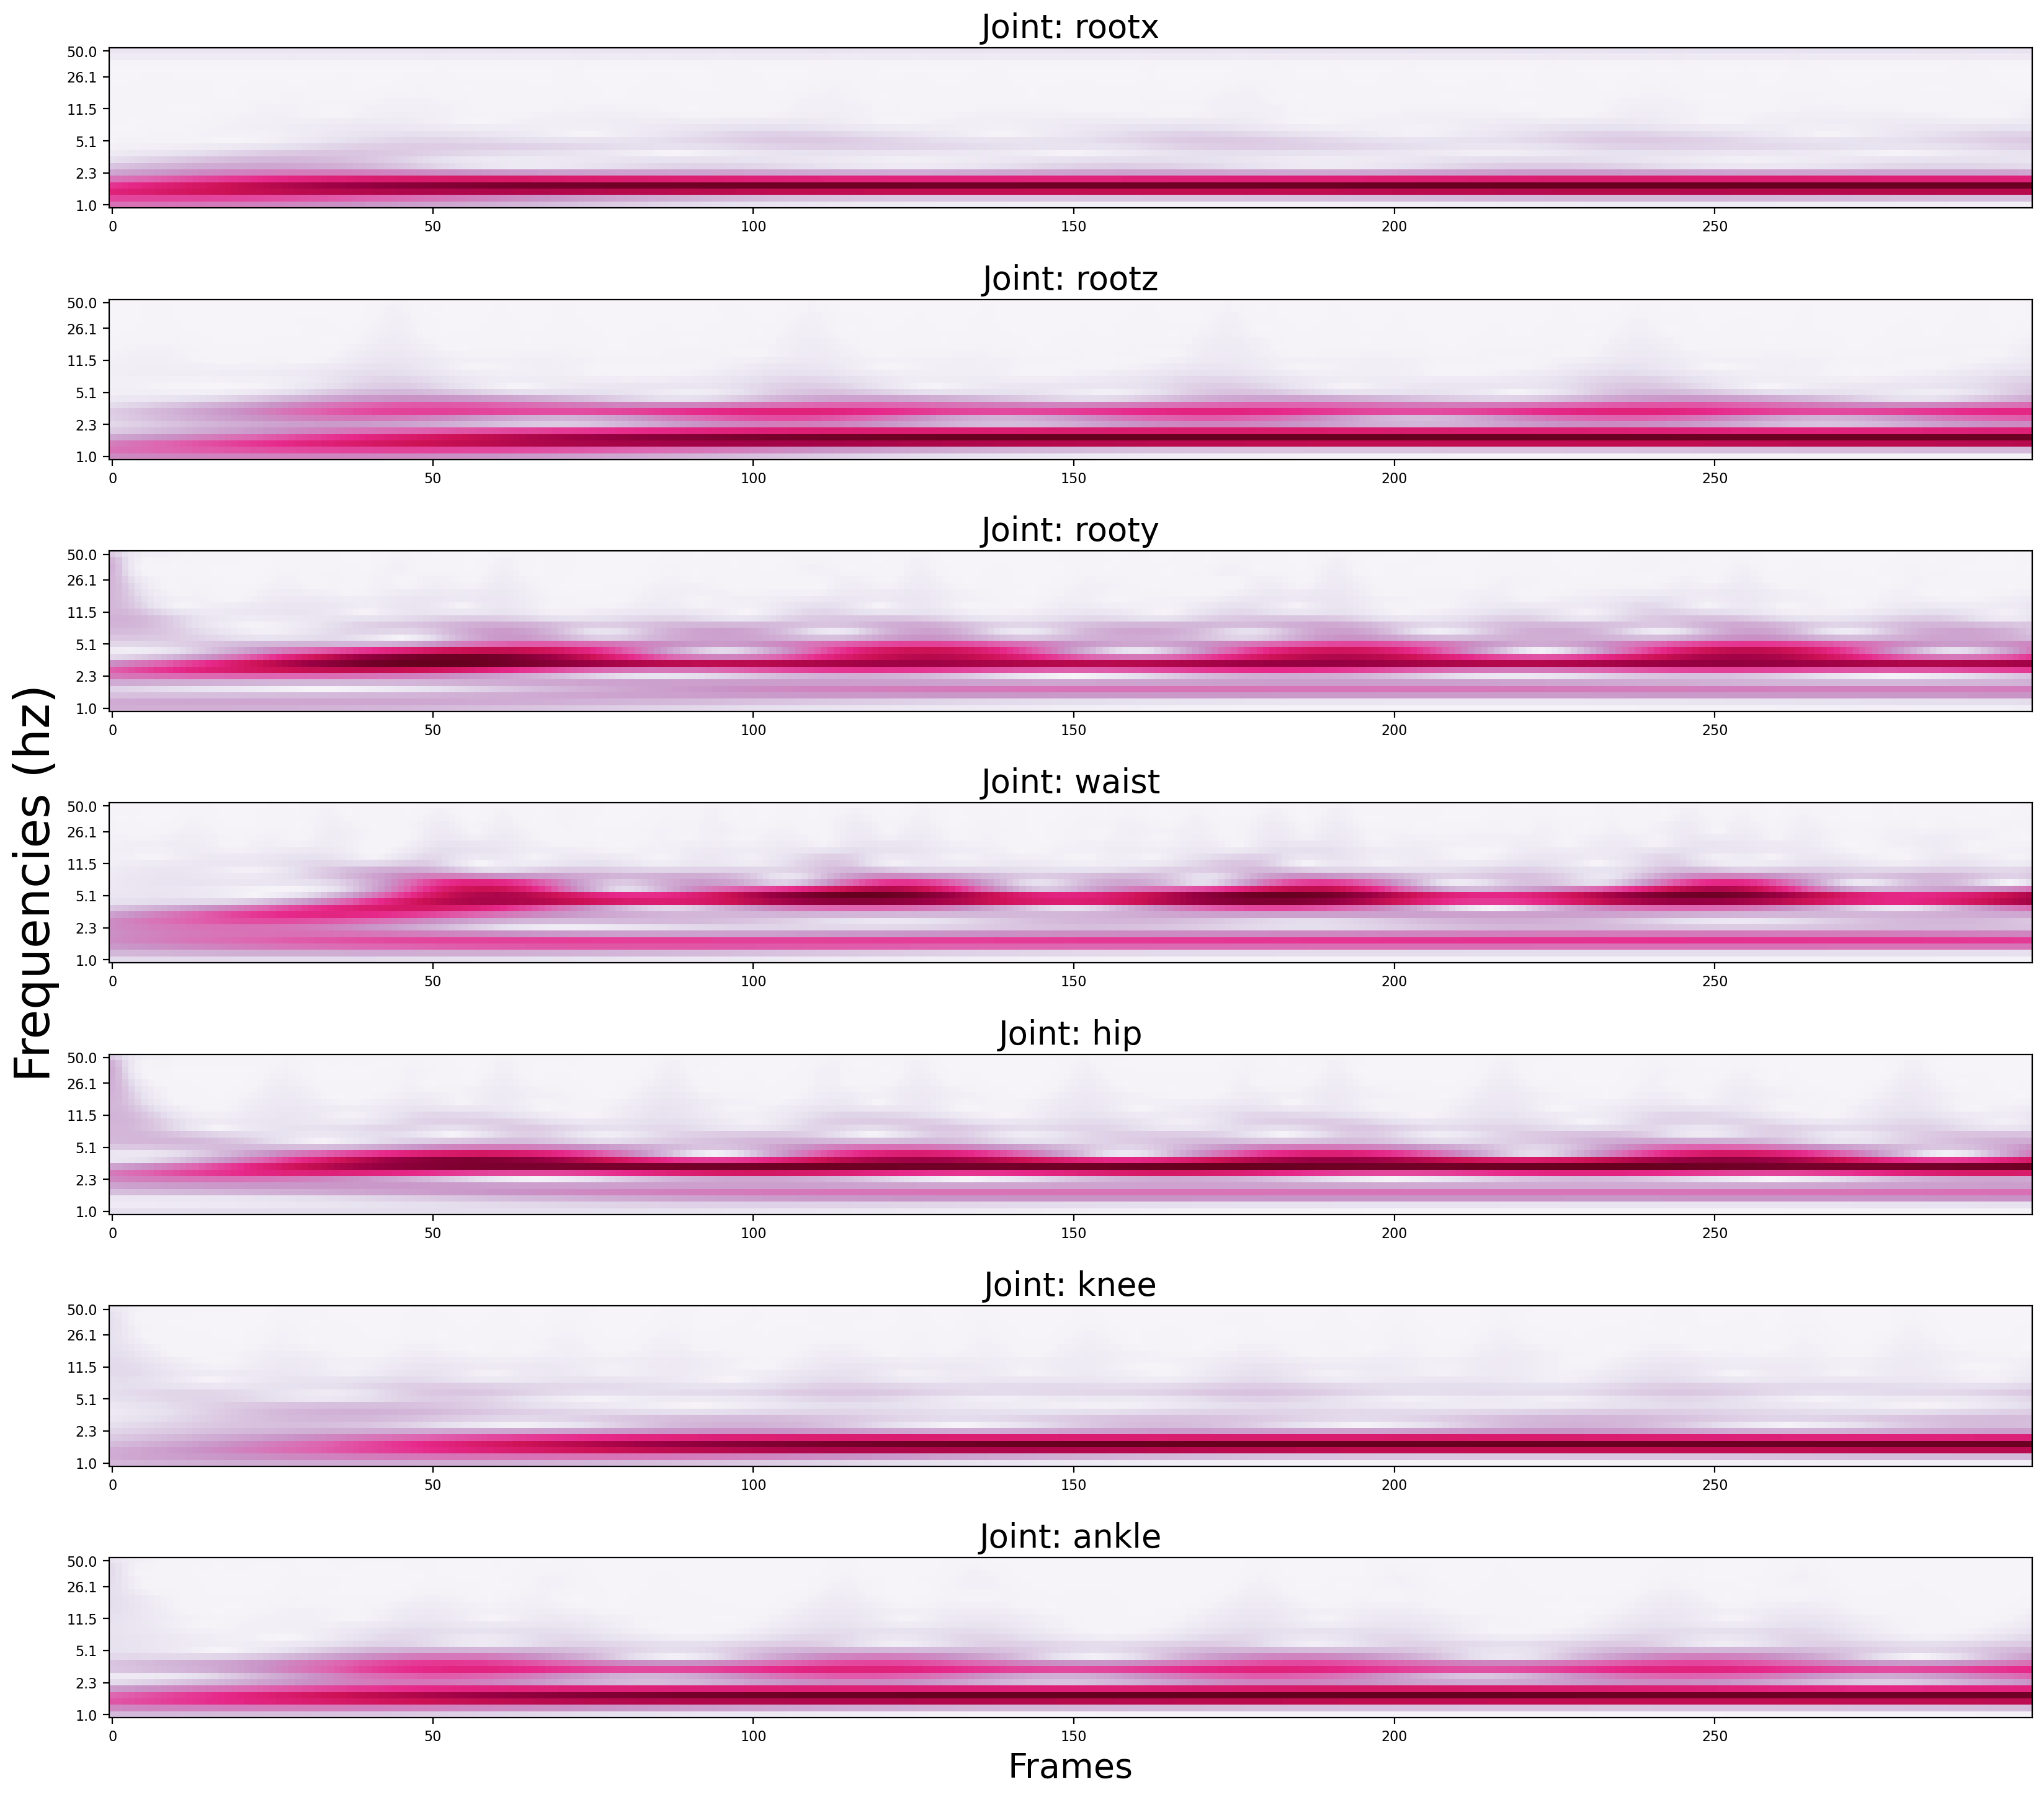

In [49]:
wlets, freqs = mmpy.findWavelets(angles, angles.shape[1],
                                 parameters.omega0, parameters.numPeriods,
                                 parameters.samplingFreq, parameters.maxF,
                                 parameters.minF, parameters.numProcessors,
                                 parameters.useGPU)

fig, axes = plt.subplots(angles.shape[1], 1, figsize=(20,18))

for i, ax in enumerate(axes.flatten()):
  ax.imshow(wlets[:300,25*i:25*(i+1)].T, cmap='PuRd', origin='lower')
  ax.set_yticks([0, 5, 10, 15, 20, 24])
  ax.set_yticklabels(['%0.1f'%freqs[j] for j in [0, 5, 10, 15, 20, 24]])
  if i == 3:
    ax.set_ylabel("Frequencies (hz)", fontsize=28)
  ax.set_title(f"Joint: {HOPPER_JOINT_NAMES[i]}", fontsize=19)
ax.set_xlabel('Frames', fontsize=20)

fig

In [33]:
position.shape

(42000, 7, 3)

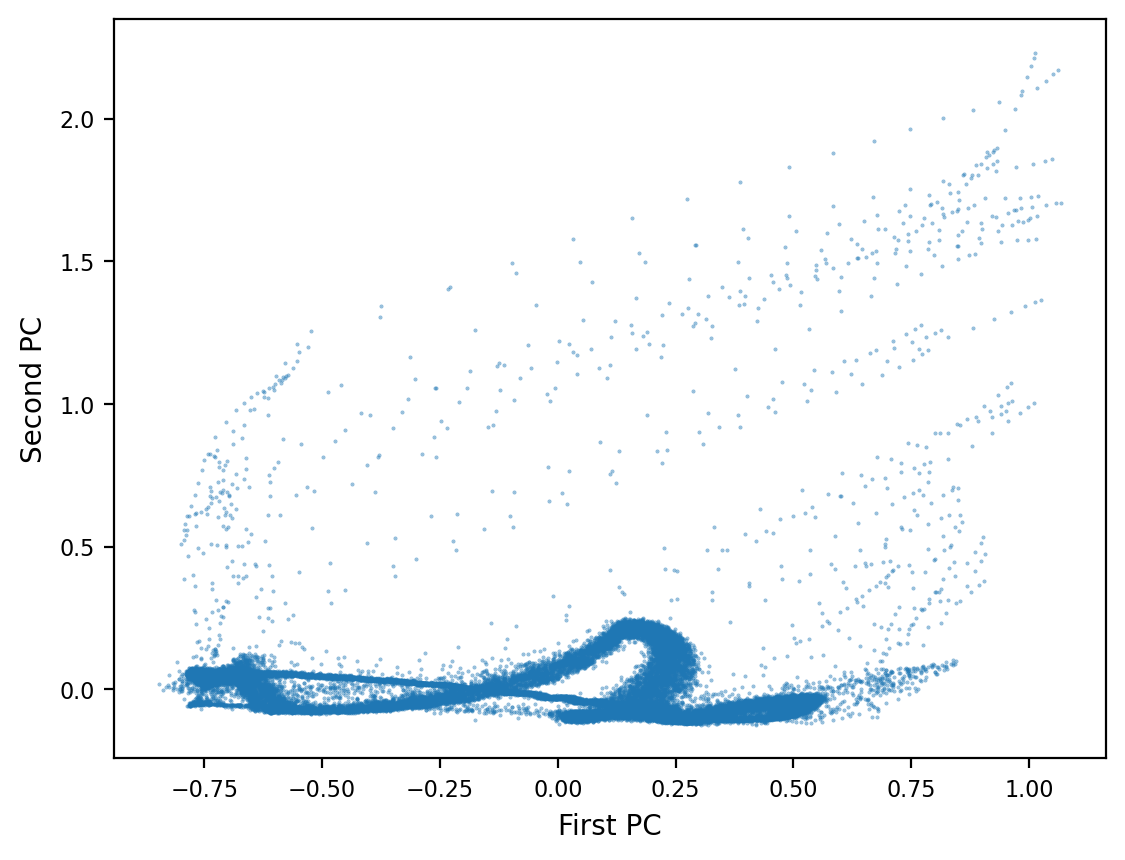

In [43]:
%matplotlib inline
position = total_kinematic_dict["geom_positions"]
pca = PCA(n_components=2)
reduced = pca.fit_transform(position[:,:,2])
plt.scatter(reduced[:, 0], reduced[:, 1], s=0.2, alpha=0.5)
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.show()

In [98]:
transformed.shape

(42000, 7)

In [ ]:
act

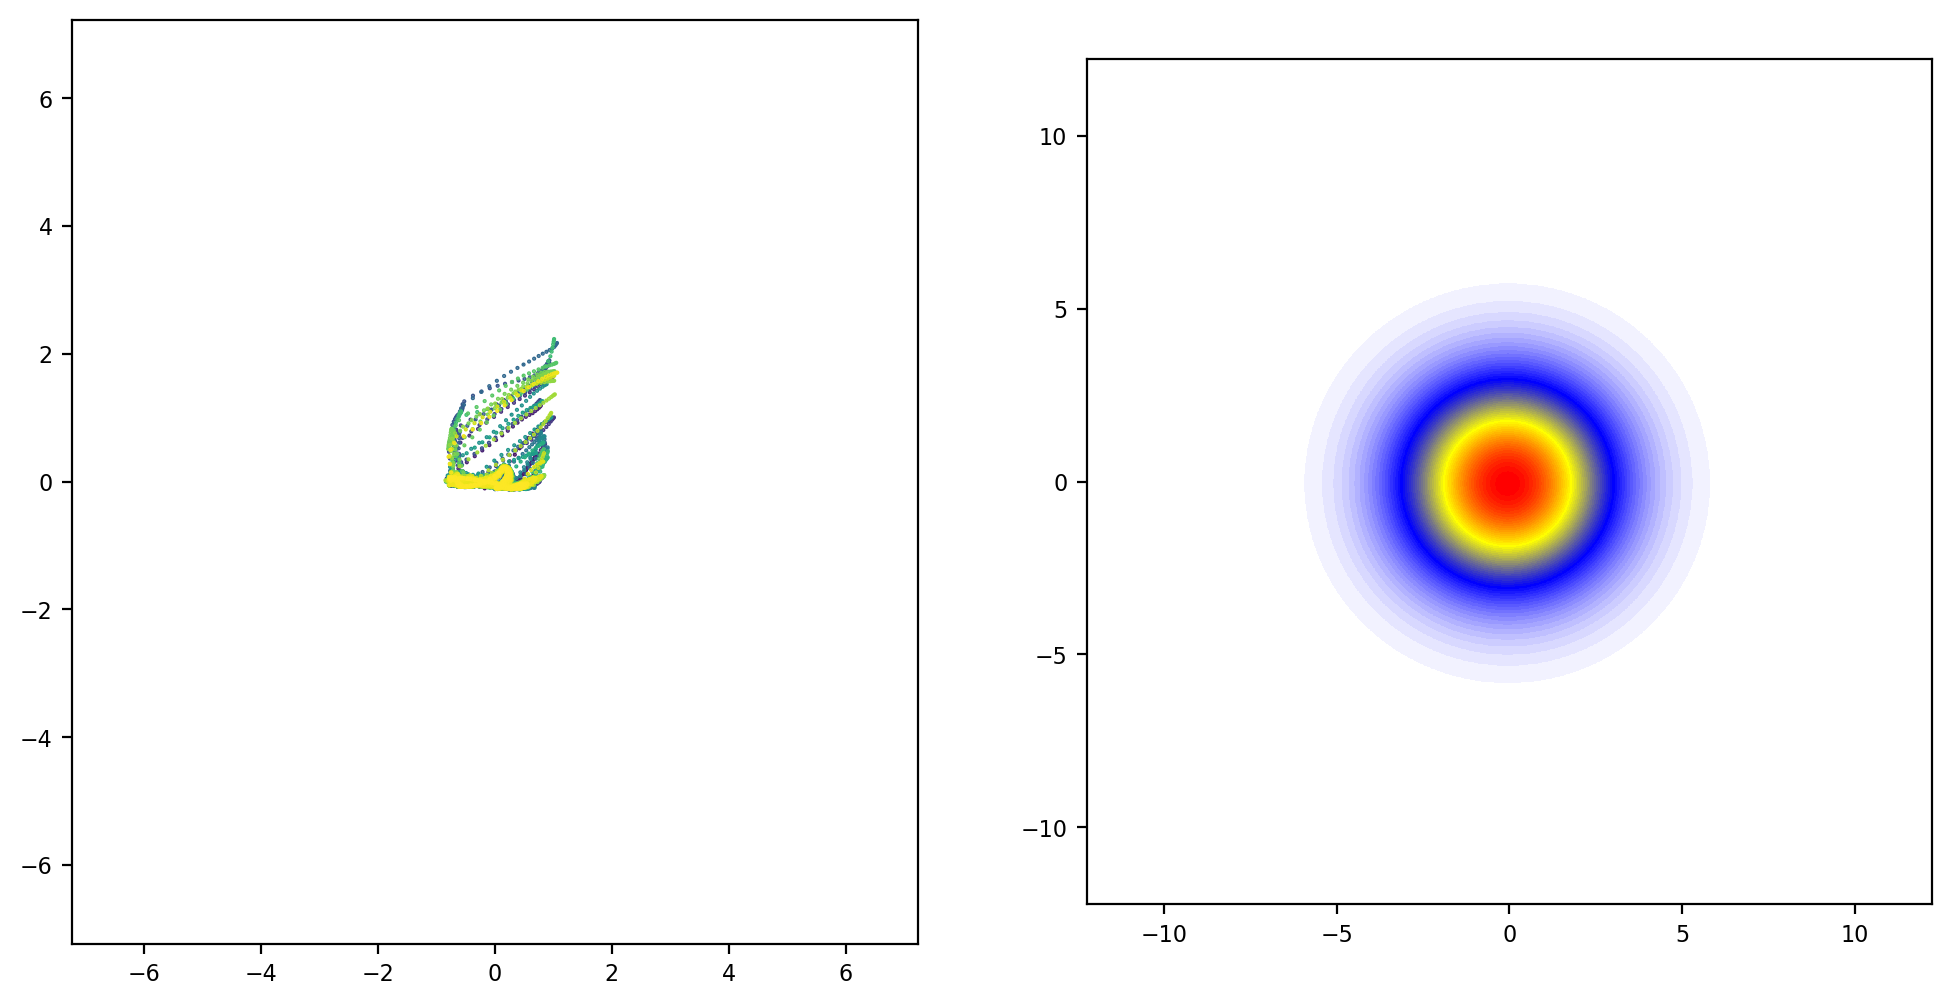

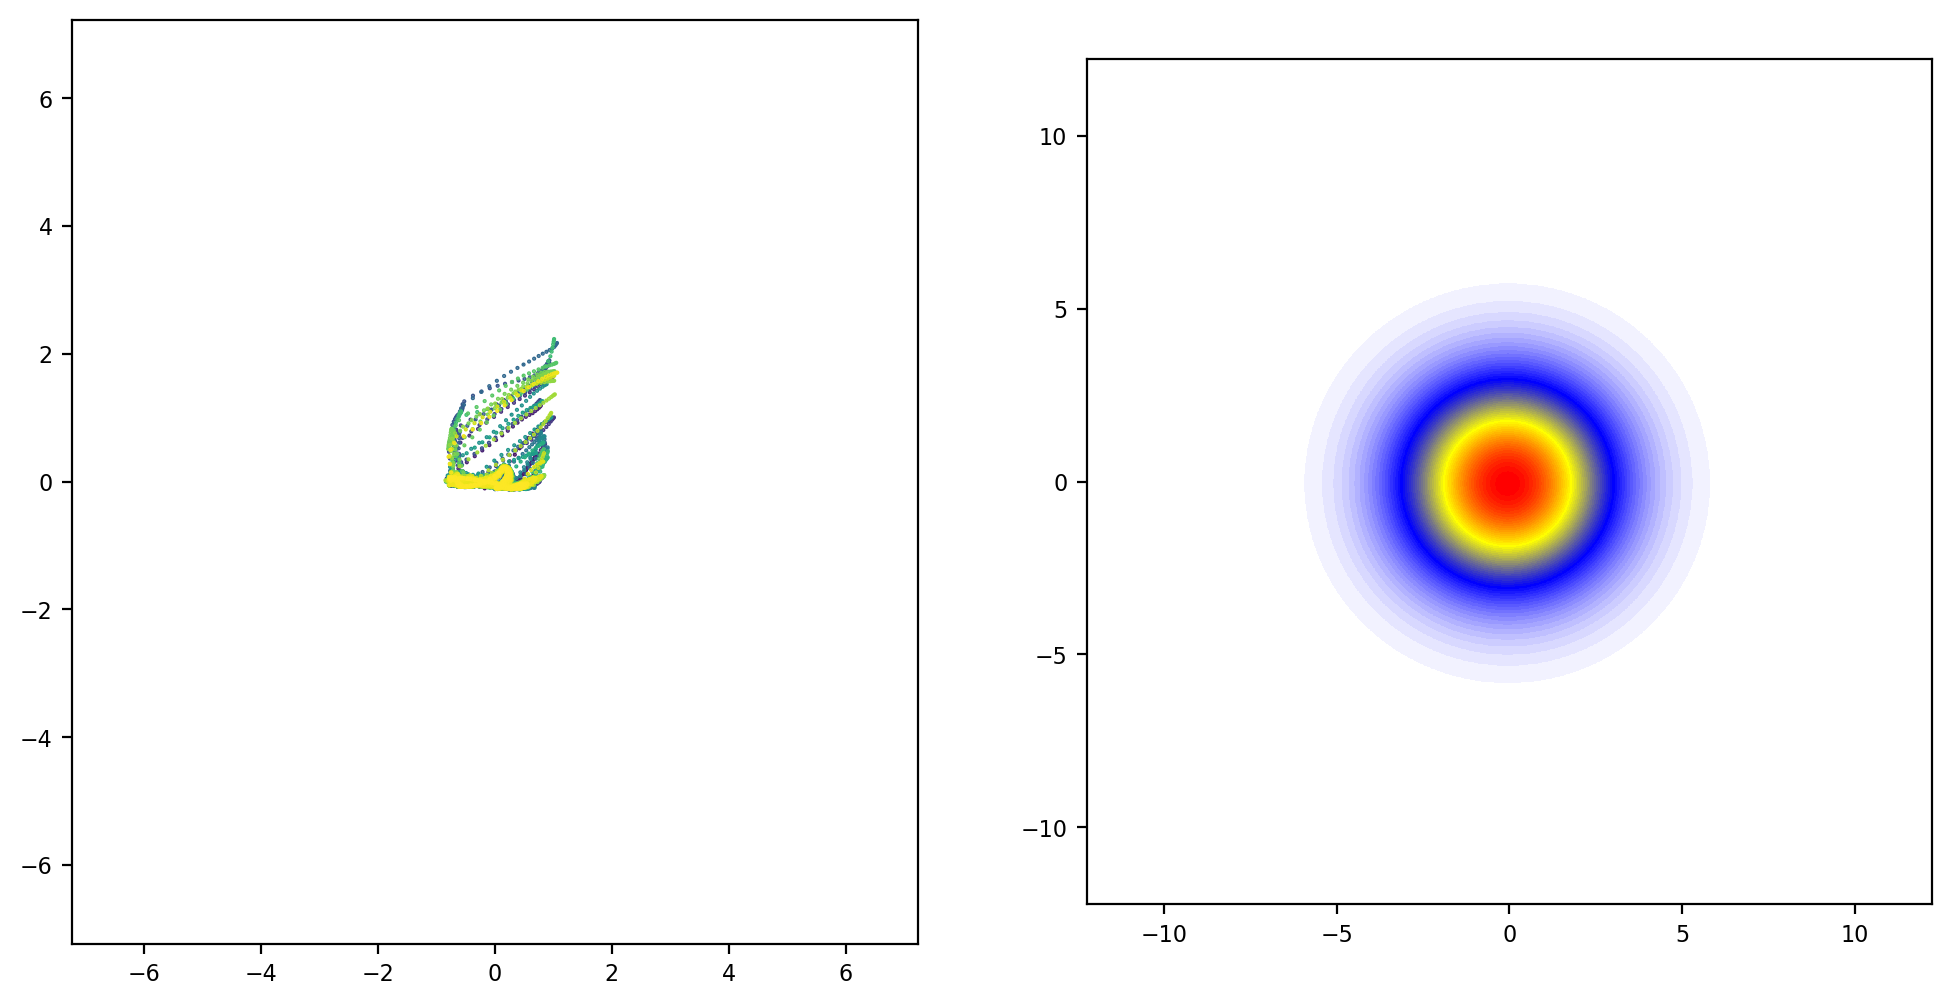

In [44]:
trainy = reduced
m = np.abs(trainy).max()


sigma=2.0
_, xx, density = mmpy.findPointDensity(trainy, sigma, 511, [-m-10, m+10])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(trainy[:,0], trainy[:,1], marker='.', c=np.arange(trainy.shape[0]), s=1)
axes[0].set_xlim([-m-5, m+5])
axes[0].set_ylim([-m-5, m+5])

axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')
fig

In [105]:
loaded_hook_dict.keys()

dict_keys(['linear1', 'linear2', 'mean_linear', 'log_std_linear'])

In [118]:
og = loaded_hook_dict["linear1"]
pca = PCA(n_components=2)
log_reduced = pca.fit_transform(og)
log_reduced

array([[-19.261915, -26.517838],
       [-17.796667, -23.695982],
       [-16.794573, -22.730543],
       ...,
       [-30.005865, -34.79403 ],
       [-38.02947 , -39.566586],
       [-46.825386, -43.568928]], dtype=float32)

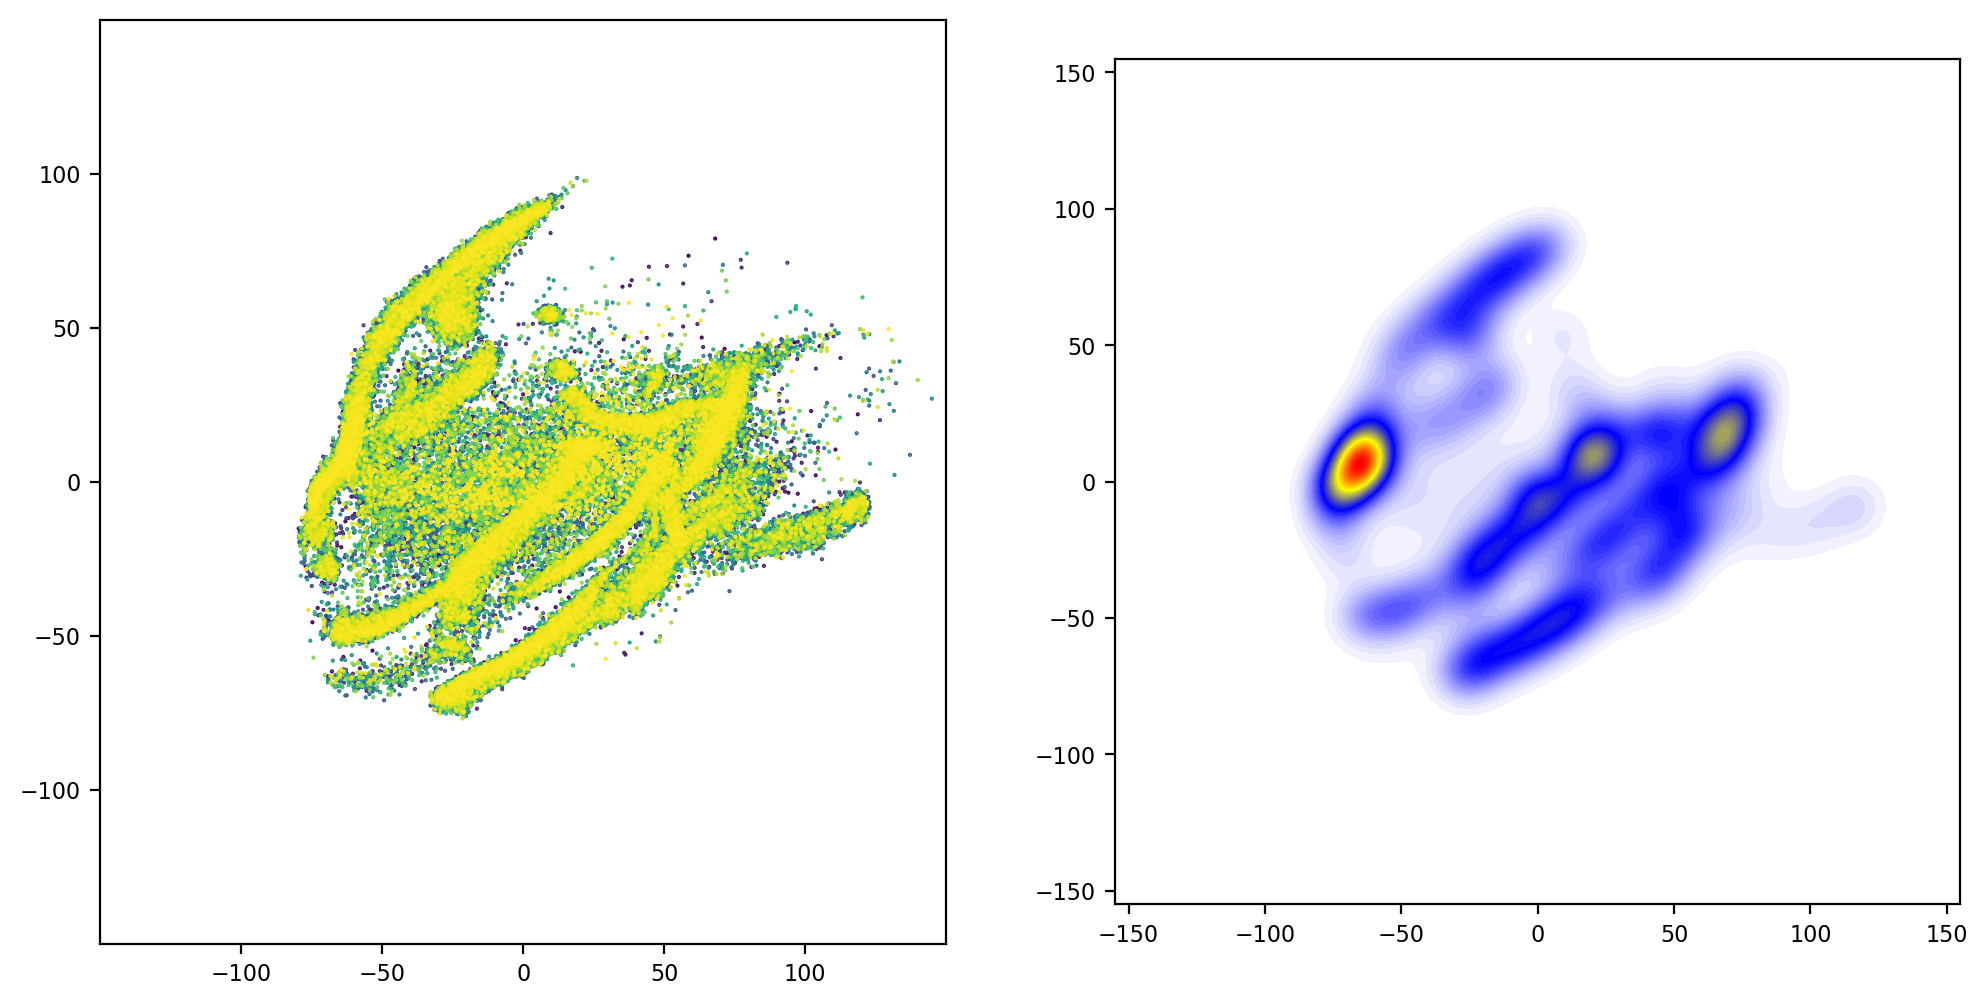

In [125]:
trainy = log_reduced
m = np.abs(trainy).max()


sigma=7
_, xx, density = mmpy.findPointDensity(trainy, sigma, 511, [-m-10, m+10])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(trainy[:,0], trainy[:,1], marker='.', c=np.arange(trainy.shape[0]), s=1)
axes[0].set_xlim([-m-5, m+5])
axes[0].set_ylim([-m-5, m+5])

axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')
fig

In [62]:
startsigma = 4.2 if parameters.method == 'TSNE' else 1.0
mmpy.findWatershedRegions(parameters, minimum_regions=10, startsigma=startsigma, pThreshold=[0.33, 0.67],
                     saveplot=True, endident = '*_pcaModes.mat')

AttributeError: 'EasyDict' object has no attribute 'projectPath'